In [1]:
# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレストによる分類器
from sklearn.model_selection import StratifiedKFold  # 層化K分割交差検証を行うクラス
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標

In [2]:
# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '../data/'


train = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

In [3]:
train.isnull().sum()

Id                    0
Year                  0
Age                 435
School                0
Height                0
Weight                0
Sprint_40yd         145
Vertical_Jump       554
Bench_Press_Reps    721
Broad_Jump          581
Agility_3cone       970
Shuttle             912
Player_Type           0
Position_Type         0
Position              0
Drafted               0
dtype: int64

In [4]:
test.isnull().sum()

Id                    0
Year                  0
Age                 115
School                0
Height                0
Weight                0
Sprint_40yd          29
Vertical_Jump       143
Bench_Press_Reps    184
Broad_Jump          147
Agility_3cone       247
Shuttle             228
Player_Type           0
Position_Type         0
Position              0
dtype: int64

In [5]:
performance_cols = [
    'Sprint_40yd',
    'Vertical_Jump',
    'Bench_Press_Reps',
    'Broad_Jump',
    'Agility_3cone',
    'Shuttle'
]


for col in performance_cols:
    # 欠損があるかどうかを新しい列として追加（0 or 1）
    train[f'{col}_missing'] = train[col].isna().astype(int)
    test[f'{col}_missing'] = test[col].isna().astype(int)

    # 欠損している元の値を -1 に置き換える（RandomForest で扱いやすい）
    train[col] = train[col].fillna(-1)
    test[col] = test[col].fillna(-1)


In [6]:
for col in performance_cols:
    missing_col = f'{col}_missing'
    print(f"\n=== {missing_col} vs Drafted ===")
    print(train.groupby(missing_col)['Drafted'].mean())



=== Sprint_40yd_missing vs Drafted ===
Sprint_40yd_missing
0    0.651745
1    0.586207
Name: Drafted, dtype: float64

=== Vertical_Jump_missing vs Drafted ===
Vertical_Jump_missing
0    0.664122
1    0.584838
Name: Drafted, dtype: float64

=== Bench_Press_Reps_missing vs Drafted ===
Bench_Press_Reps_missing
0    0.664563
1    0.601942
Name: Drafted, dtype: float64

=== Broad_Jump_missing vs Drafted ===
Broad_Jump_missing
0    0.662727
1    0.593804
Name: Drafted, dtype: float64

=== Agility_3cone_missing vs Drafted ===
Agility_3cone_missing
0    0.671452
1    0.605155
Name: Drafted, dtype: float64

=== Shuttle_missing vs Drafted ===
Shuttle_missing
0    0.671482
1    0.600877
Name: Drafted, dtype: float64


欠損なしの方がドラフト率は高い

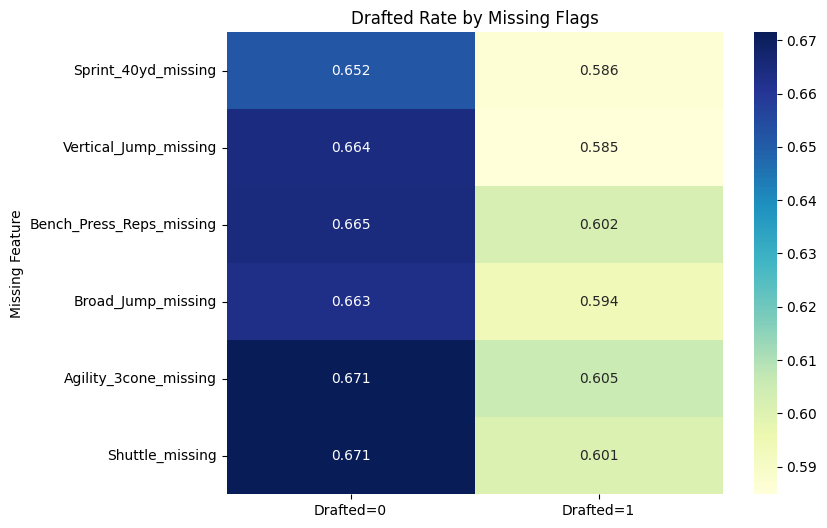

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 欠損フラグとDraftedの関係をクロス集計（平均値 = 指名率）
heatmap_data = pd.DataFrame({
    f'{col}_missing': train.groupby(f'{col}_missing')['Drafted'].mean()
    for col in performance_cols
}).T

# 列名をわかりやすく
heatmap_data.columns = ['Drafted=0', 'Drafted=1'] if heatmap_data.shape[1] == 2 else ['Drafted Rate']

# ヒートマップの描画
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title("Drafted Rate by Missing Flags")
plt.ylabel("Missing Feature")
plt.show()


In [8]:
# パフォーマンス系の欠損列を対象にカウント（※すでに_missing列があることが前提）
train['Num_Missing_Tests'] = train[[f'{col}_missing' for col in performance_cols]].sum(axis=1)
test['Num_Missing_Tests'] = test[[f'{col}_missing' for col in performance_cols]].sum(axis=1)



In [9]:
print(train.groupby('Num_Missing_Tests')['Drafted'].mean())

Num_Missing_Tests
0    0.687545
1    0.632159
2    0.617100
3    0.591241
4    0.627119
5    0.529167
6    0.696429
Name: Drafted, dtype: float64


欠損値の種類が多いほど、ドラフト率が多いと予測したが、４種類、6種類ではあまり効果を得られず。
次に件数も表示してみる。


In [10]:
# Draft率と件数を集計
missing_stats = train.groupby('Num_Missing_Tests')['Drafted'].agg(['mean', 'count']).rename(columns={
    'mean': 'Draft Rate',
    'count': 'Number of Players'
})

# ソートして表示
print(missing_stats.sort_index())


                   Draft Rate  Number of Players
Num_Missing_Tests                               
0                    0.687545               1389
1                    0.632159                454
2                    0.617100                269
3                    0.591241                137
4                    0.627119                236
5                    0.529167                240
6                    0.696429                 56


任意の2つを組み合わせたときにドラフト率に大きな影響がないか確認

In [11]:
for col in performance_cols:
    print(f"{col}: {train[col].isna().sum()}")

Sprint_40yd: 0
Vertical_Jump: 0
Bench_Press_Reps: 0
Broad_Jump: 0
Agility_3cone: 0
Shuttle: 0


In [12]:
# 列名一覧を確認（コピー用）
print(train.columns.tolist())


['Id', 'Year', 'Age', 'School', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle', 'Player_Type', 'Position_Type', 'Position', 'Drafted', 'Sprint_40yd_missing', 'Vertical_Jump_missing', 'Bench_Press_Reps_missing', 'Broad_Jump_missing', 'Agility_3cone_missing', 'Shuttle_missing', 'Num_Missing_Tests']


In [13]:
print(train.shape)
print(train[['Sprint_40yd', 'Vertical_Jump']].isna().sum())
print(train.loc[:, 'Drafted'].head())


(2781, 23)
Sprint_40yd      0
Vertical_Jump    0
dtype: int64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Drafted, dtype: float64


In [14]:
train = pd.read_csv('../data/train.csv')  # 欠損が復活する
test = pd.read_csv('../data/test.csv')  # 欠損が復活する



In [15]:
from itertools import combinations
import pandas as pd

# train.csv を読み込んでいない場合は以下で読み込む
# train = pd.read_csv('../data/train.csv')

# パフォーマンス系の列
performance_cols = [
    'Sprint_40yd',
    'Vertical_Jump',
    'Bench_Press_Reps',
    'Broad_Jump',
    'Agility_3cone',
    'Shuttle'
]

# 結果格納用リスト
results = []

# 全ての2列ペアに対して、ANDで欠損している行を抽出して分析
for col1, col2 in combinations(performance_cols, 2):
    both_missing = train[col1].isna() & train[col2].isna()
    count = both_missing.sum()

    if count > 0:
        draft_rate = train.loc[both_missing, 'Drafted'].mean()  # skipna=True は不要（デフォルト）
    else:
        draft_rate = None

    results.append({
        'Feature_Pair': f'{col1} & {col2}',
        'Draft Rate': draft_rate,
        'Sample Count': count
    })

# 結果をDataFrame化してソート
pair_df = pd.DataFrame(results).sort_values(by='Draft Rate', ascending=False)

# 結果を表示
print(pair_df)


                        Feature_Pair  Draft Rate  Sample Count
1     Sprint_40yd & Bench_Press_Reps    0.709677            62
0        Sprint_40yd & Vertical_Jump    0.640000           100
2           Sprint_40yd & Broad_Jump    0.627451           102
3        Sprint_40yd & Agility_3cone    0.625000           120
4              Sprint_40yd & Shuttle    0.623932           117
14           Agility_3cone & Shuttle    0.600227           883
8            Vertical_Jump & Shuttle    0.591682           529
7      Vertical_Jump & Agility_3cone    0.591337           531
12        Broad_Jump & Agility_3cone    0.590909           550
13              Broad_Jump & Shuttle    0.590826           545
6         Vertical_Jump & Broad_Jump    0.589147           516
11        Bench_Press_Reps & Shuttle    0.578512           363
10  Bench_Press_Reps & Agility_3cone    0.575676           370
9      Bench_Press_Reps & Broad_Jump    0.557143           280
5   Vertical_Jump & Bench_Press_Reps    0.541045       

     Sprint_40yd & Bench_Press_Reps    0.709677            62
     はかなり有効そうに感じる

In [16]:
# 使わない列の削除
train = train.drop(columns=["Id", "School"])
test = test.drop(columns=["Id","School"])

「Sprint_40yd_and_Bench_missing」は、元の値とは別の情報をもつ新しい視点の特徴量となります。

In [17]:
# 欠損フラグの特徴量を追加
train['Sprint_40yd_missing'] = train['Sprint_40yd'].isna().astype(int)
test['Sprint_40yd_missing'] = test['Sprint_40yd'].isna().astype(int)

train['Sprint_40yd_and_Bench_missing'] = (train['Sprint_40yd'].isna() & train['Bench_Press_Reps'].isna()).astype(int)
test['Sprint_40yd_and_Bench_missing'] = (test['Sprint_40yd'].isna() & test['Bench_Press_Reps'].isna()).astype(int)


In [18]:
train[['Sprint_40yd', 'Bench_Press_Reps', 'Sprint_40yd_missing', 'Sprint_40yd_and_Bench_missing']].head(10)


,Sprint_40yd,Bench_Press_Reps,Sprint_40yd_missing,Sprint_40yd_and_Bench_missing
0,5.39,29.0,0,0
1,4.31,16.0,0,0
2,4.51,10.0,0,0
3,5.09,39.0,0,0
4,4.64,NaN,0,0
5,4.58,27.0,0,0
6,4.42,12.0,0,0
7,4.61,11.0,0,0
8,5.36,NaN,0,0
9,5.15,19.0,0,0


In [19]:
# 平均で補完する対象の列
cols_to_fill = ['Age', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
                'Broad_Jump', 'Agility_3cone', 'Shuttle']

# train の平均で train/test 両方を補完
for col in cols_to_fill:
    mean_value = train[col].mean()
    train[col] = train[col].fillna(mean_value)
    test[col] = test[col].fillna(mean_value)

In [20]:
train.isnull().sum()

Year                             0
Age                              0
Height                           0
Weight                           0
Sprint_40yd                      0
Vertical_Jump                    0
Bench_Press_Reps                 0
Broad_Jump                       0
Agility_3cone                    0
Shuttle                          0
Player_Type                      0
Position_Type                    0
Position                         0
Drafted                          0
Sprint_40yd_missing              0
Sprint_40yd_and_Bench_missing    0
dtype: int64

In [21]:
train.head()


,Year,Age,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Player_Type,Position_Type,Position,Drafted,Sprint_40yd_missing,Sprint_40yd_and_Bench_missing
0,2011,21.0,1.9050,140.160042,5.39,59.69,29.000000,251.46,7.910000,4.940000,offense,offensive_lineman,OG,1.0,0,0
1,2011,24.0,1.8288,87.089735,4.31,101.60,16.000000,332.74,7.230447,4.399422,offense,backs_receivers,WR,1.0,0,0
2,2018,21.0,1.8542,92.986436,4.51,91.44,10.000000,309.88,6.950000,4.370000,offense,backs_receivers,WR,1.0,0,0
3,2010,21.0,1.9304,148.778297,5.09,76.20,39.000000,254.00,8.120000,4.710000,defense,defensive_lineman,DT,1.0,0,0
4,2016,21.0,1.8796,92.079251,4.64,78.74,20.236408,281.94,7.130000,4.200000,offense,backs_receivers,WR,1.0,0,0


In [22]:
test.isnull().sum()

Year                             0
Age                              0
Height                           0
Weight                           0
Sprint_40yd                      0
Vertical_Jump                    0
Bench_Press_Reps                 0
Broad_Jump                       0
Agility_3cone                    0
Shuttle                          0
Player_Type                      0
Position_Type                    0
Position                         0
Sprint_40yd_missing              0
Sprint_40yd_and_Bench_missing    0
dtype: int64

In [23]:
for df in [train, test]:
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)

In [24]:
# カテゴリデータをラベルエンコーディング
label_encoders = {}
for c in ["Player_Type", "Position_Type", "Position"]:
    label_encoders[c] = LabelEncoder()
    train[c] = label_encoders[c].fit_transform(train[c].astype(str))
    test[c] = label_encoders[c].transform(test[c].astype(str))

In [25]:
# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=2025
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア格納用
train_auc_scores = []
valid_auc_scores = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model.fit(X_train, y_train)

    # Train AUC
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    train_auc_scores.append(train_auc)

    # Valid AUC
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    valid_auc = roc_auc_score(y_valid, y_valid_pred_proba)
    valid_auc_scores.append(valid_auc)

    print(f"  Train AUC: {round(train_auc, 4)}")
    print(f"  Valid AUC: {round(valid_auc, 4)}")

# 平均AUCを表示
print("\nAverage Train AUC:", round(np.mean(train_auc_scores), 4))
print("Average Validation AUC:", round(np.mean(valid_auc_scores), 4))


Fold 1
  Train AUC: 0.8846
  Valid AUC: 0.7912
Fold 2
  Train AUC: 0.8819
  Valid AUC: 0.8373
Fold 3
  Train AUC: 0.8828
  Valid AUC: 0.8397
Fold 4
  Train AUC: 0.8875
  Valid AUC: 0.7843
Fold 5
  Train AUC: 0.8829
  Valid AUC: 0.8306

Average Train AUC: 0.8839
Average Validation AUC: 0.8166


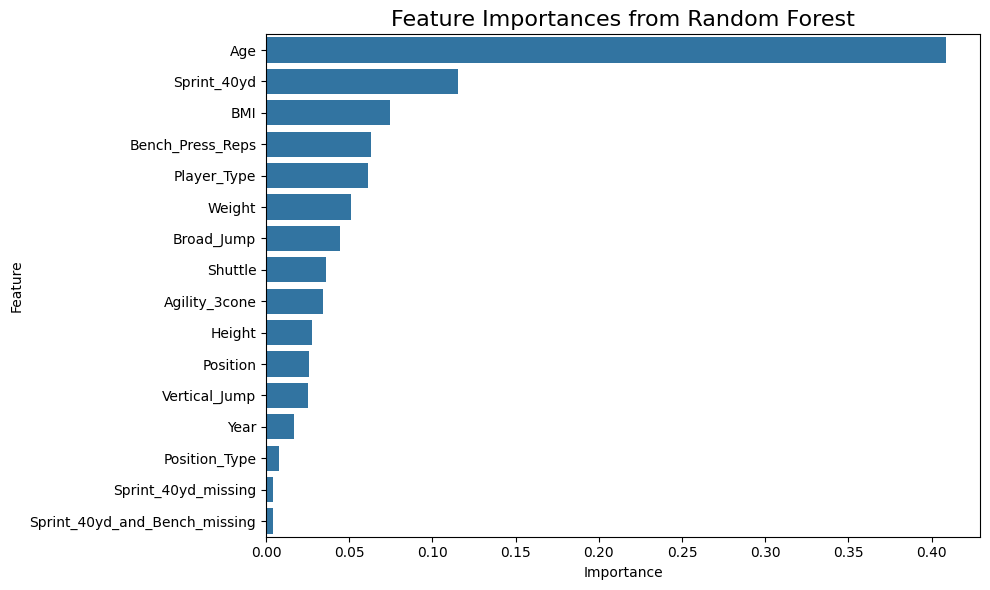

In [90]:
# 特徴量とその重要度をDataFrameにまとめる
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances from Random Forest', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [93]:
import pandas as pd
import os
import datetime

# Idの復元用に改めて test.csv を読み込む（こちらは未加工）
original_test = pd.read_csv("../data/test.csv")  # ← ここを修正！

# 予測確率（Drafted=1 の確率）
y_pred = model.predict_proba(test[feature_cols])[:, 1]


# 提出用 DataFrame（上で定義した y_pred 使用）
submission = pd.DataFrame({
    "Id": original_test["Id"],
    "Drafted": y_pred
})

# 📁 正しい保存先（プロジェクトルート直下の submissions フォルダ）
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # ← notebooks/ の1つ上へ
save_dir = os.path.join(root_dir, "submissions")
os.makedirs(save_dir, exist_ok=True)

# ファイル名：日時付き
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
save_path = os.path.join(save_dir, f"submission_{timestamp}.csv")

# 保存
submission.to_csv(save_path, index=False)
print(f"✅ 保存完了: {save_path}")


✅ 保存完了: c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\submissions\submission_20250623_0201.csv
